In [5]:
import matplotlib.pyplot as plt
import time
import numpy as np
import csv
import os

from maya import SerialCommunication, PCF8575Control_, MFCControl

In [6]:
def generate_sequence(n_reps=20):
    sequence = n_reps*list(range(1,4))
    np.random.shuffle(sequence)
    return sequence


In [12]:
# Serial port configuration
PORT = "/dev/ttyACM0"  # Replace with your Teensy's serial port
BAUDRATE = 115200  # Match the baud rate used in the Teensy program
PACKET_SIZE = 128  # Size of each data packet (bytes)
FREQUENCY = 1  # Sampling frequency (Hz)

#PCF8575 configuration
PCF_flags = [True for i in range(16)]           # All sensors ON
PCF_frequencies = ["0" for i in range(16)]      # All sensors at 0Hz

# DAC configuration
dac1_value = 800
dac2_value = 200

sensor_id = ["U1-TGS2602", "U2-TGS2610-D00", "U3-SP3S-AQ2", "U4-GSBT11-DXX",
             "U8-TGS2600", "U9-TGS2603", "U10-TGS2630", "U13-TGS2612-D00",
             "U14-TGS2620", "U15-MG-812", "U16-TGS-3830", "U19-TGS1820",
             "U20-TGS2611-E00", "U21-TGS2616-C00", "U22-WSP2110", "U25-TGS-3870",
             "U7-BME680"]

sensor_addr = [[0x49, 1],[0x49, 3],[0x4b, 2],[0x4b, 3],
               [0x49, 0],[0x49, 2],[0x4b, 0],[0x48, 1],
               [0x48, 3],[0x4a, 1],[0x4a, 3],[0x4a, 2],
               [0x48, 0],[0x48, 2],[0x4a, 0],[0x4b, 1],
               [0x76, 99]]

sensor_addr_to_tag = [[0x49, 0], [0x4b, 1], [0x48, 2], [0x4a, 3],]

adc_addr = [0x48, 0x49, 0x4a, 0x4b]

# Setting up the serial communication
serial_comm = SerialCommunication(PORT, BAUDRATE)

# Setting up DAC values and sampling frequency
message = f"{dac1_value},{dac2_value},{FREQUENCY}\n"
serial_comm.send_message(message)

# Setting the PCF8575 state
PCF_control = PCF8575Control_(serial_comm, flags=PCF_flags, frequencies=PCF_frequencies)
PCF_control.send_state()

# Setting MFCs
MFC_control = MFCControl(serial_comm)
for i in range(3):
    MFC_control.set_flow(i, 0.)

# Recording
t_baseline = 60
t_sample = 20
n_sequence = 30
filename = f"data/1_{n_sequence}_20.csv"

sequence = generate_sequence(int(n_sequence/3))
data = []
times_seq = []
if os.path.exists(filename):
    os.remove(filename)

# Flushing sensors & setting baseline
for read in serial_comm.stream_data(t_baseline, save_csv=True, filename=filename):
    pass

# Random sequence
for i in range(len(sequence)):
    times_seq.append((time.asctime(), sequence[i]))
    MFC_control.set_flow(sequence[i], 1.)
    for read in serial_comm.stream_data(t_sample, save_csv=True, filename=filename):
        # data.append(read)
        pass
    MFC_control.set_flow(sequence[i], 0.)

# # Baseline again
# MFC_control.set_flow(3, 1.)
# for read in serial_comm.stream_data(t_sample, save_csv=True, filename=filename):
#     data.append(read)
# MFC_control.set_flow(3, 0.)

# serial_comm.close()

import pickle

with open(f'{filename}_sequence.pkl', 'wb') as f:
    pickle.dump(times_seq, f)



Sent to Teensy: 800,200,1
Sent to Teensy: PCF,64575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PCF8575 state and frequencies updated:
State: 0b1111110000111111
Frequencies: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sent to Teensy: MFC,0,1,0
MFC 0 flow rate updated: 0.0
Sent to Teensy: MFC,1,1,0
MFC 1 flow rate updated: 0.0
Sent to Teensy: MFC,2,1,0
MFC 2 flow rate updated: 0.0
Sent to Teensy: MAYA,1
Created and started writing to data/1_30_20.csv.
Streaming data...
Sent to Teensy: MAYA,0
Done
Sent to Teensy: MFC,2,1,32000
MFC 2 flow rate updated: 1.0
Sent to Teensy: MAYA,1
Appending data to existing file data/1_30_20.csv.
Streaming data...
Sent to Teensy: MAYA,0
Done
Sent to Teensy: MFC,2,1,0
MFC 2 flow rate updated: 0.0
Sent to Teensy: MFC,3,1,32000
MFC 3 flow rate updated: 1.0
Sent to Teensy: MAYA,1
Appending data to existing file data/1_30_20.csv.
Streaming data...
Sent to Teensy: MAYA,0
Done
Sent to Teensy: MFC,3,1,0
MFC 3 flow rate updated: 0.0
Sent to Teensy: MFC,3,1,32000
MFC 3 flow rate updated: 1.

In [8]:
import pickle

with open(f'{filename}_sequence.pkl', 'wb') as f:
    pickle.dump(times_seq, f)

In [4]:
with open (f'data/1_600_20.csv_sequence.pkl', 'rb') as f:
    times_seq = pickle.load(f)

In [4]:
sensor_data = []
times = []
with open('data/test_sequence_.csv', 'r') as f:
    reader = csv.reader(f)
    # times = [row[0] for row in reader]
    for row in reader:
        if row[0] =='Timestamp':
            continue
        else:
            times.append(row[0])
            values = []
            for i in range(17):
                b1 = int(row[2*i+1])
                b2 = int(row[2*i+2])
                values.append(int.from_bytes([b1, b2], byteorder="little"))
            sensor_data.append(values)
sensor_data = np.array(sensor_data)


In [8]:
times[0], times[-1]

('2025-07-18 17:14:50.822849', '2025-07-18 18:53:50.031870')

In [5]:
sensor_data

array([[    0,  4614,     4, ...,   241,  1421,  1000],
       [    0,  4456,     4, ...,   241,  1421,  1000],
       [    0,  4238,     4, ...,   240,  1421,  1000],
       ...,
       [    0,   457,     4, ...,    98,  1426,  1000],
       [    0,   449,     4, ...,    98,  1427,  1000],
       [65535,   441,     4, ...,    98,  1426,  1000]])

/tmp/ipykernel_13211/618733780.py:14: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax[i,j].set_xticks([])
/tmp/ipykernel_13211/618733780.py:14: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax[i,j].set_xticks([])
/tmp/ipykernel_13211/618733780.py:14: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax[i,j].set_xticks([])
/tmp/ipykernel_13211/618733780.py:14: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax[

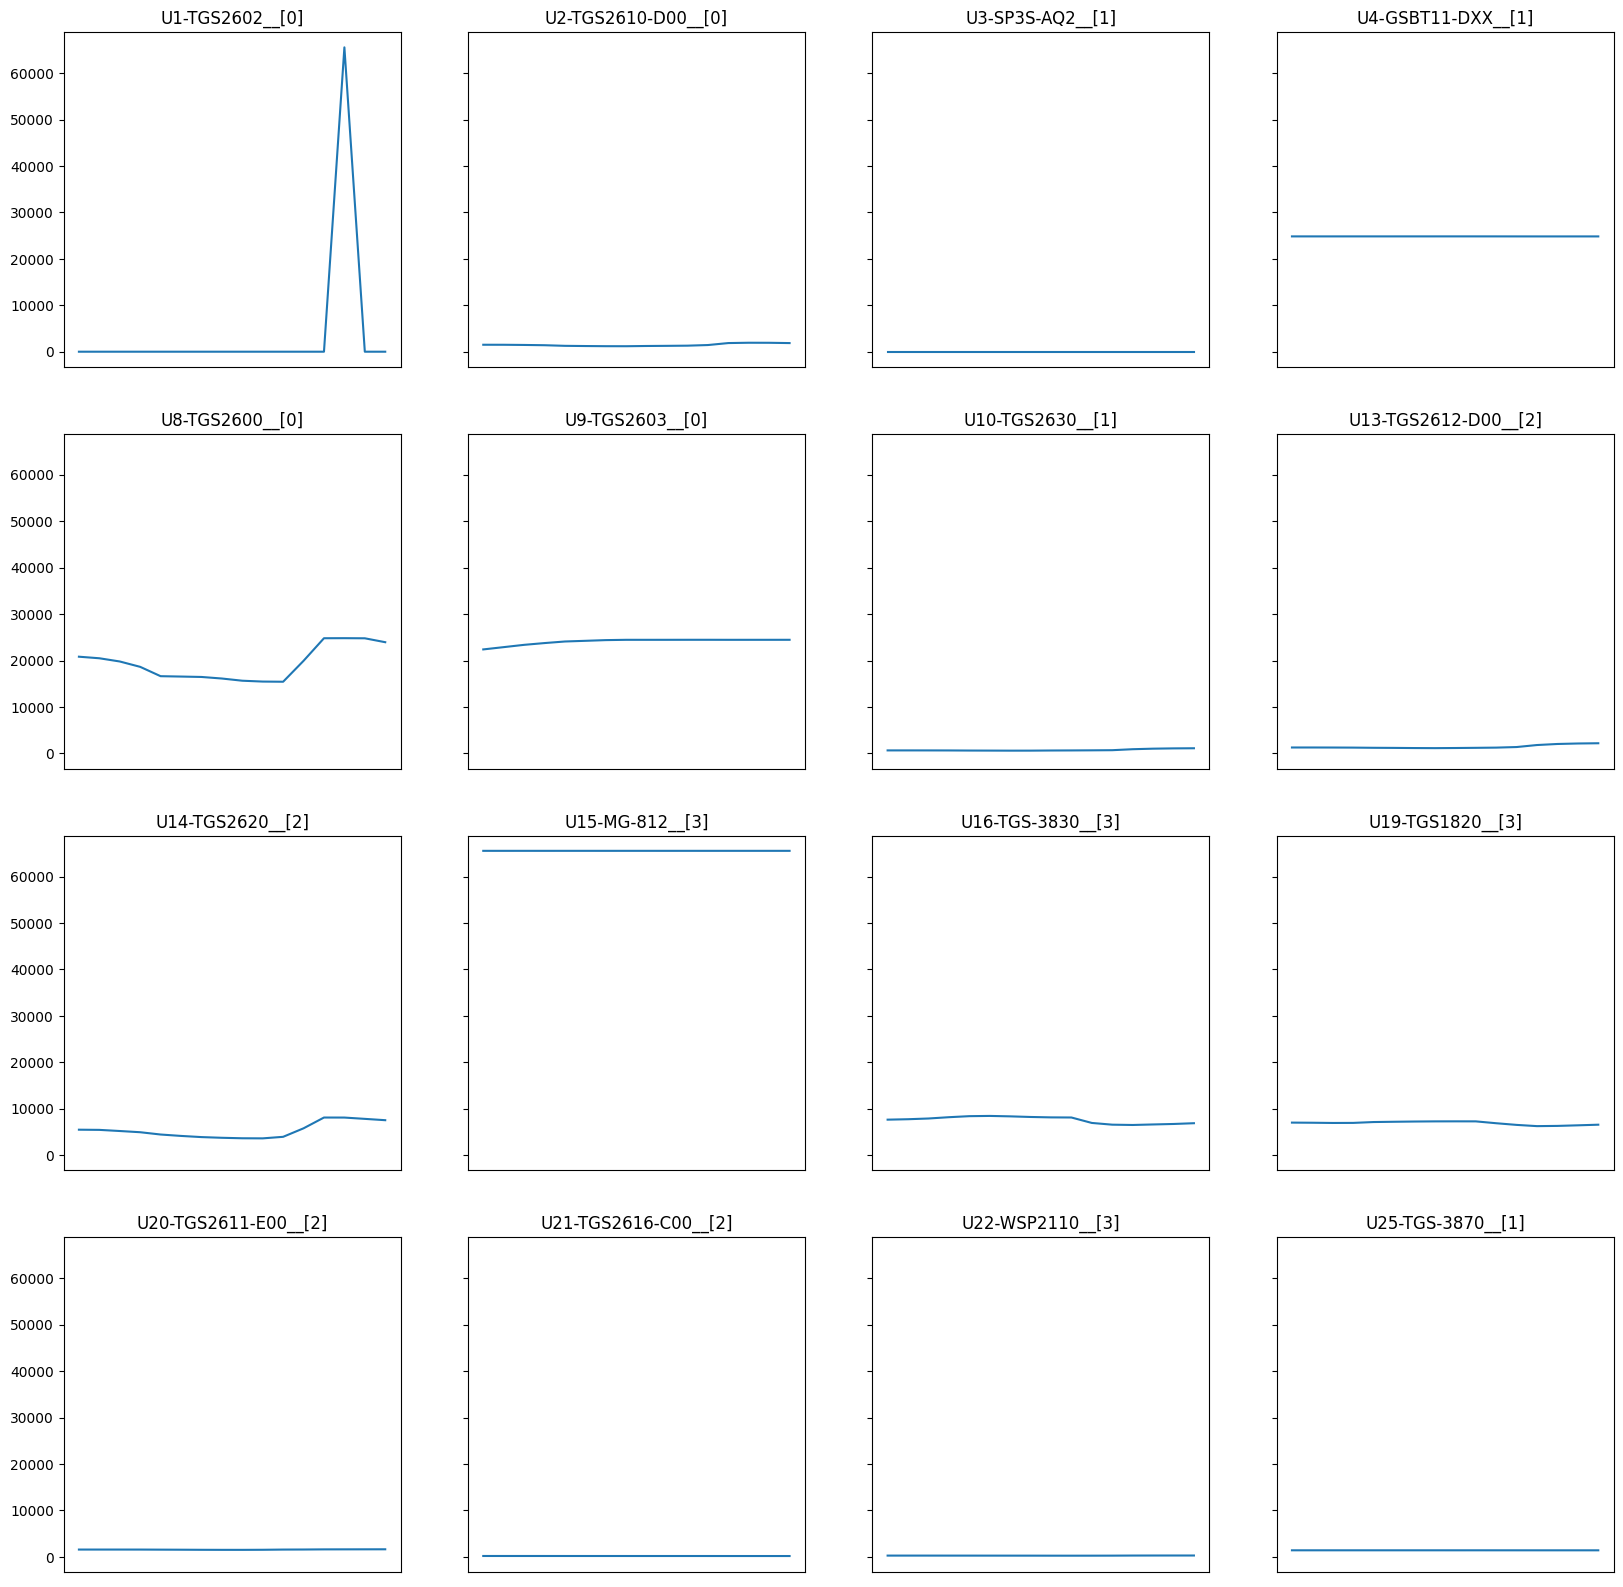

In [35]:
# times = [read[0] for read in data]
#
# sensor_data = []
# for i in range(16):
#     values = []
#     for read in data:
#         values.append(int.from_bytes(read[2*i+1:2*i+3], byteorder="little"))    # Check with Herman
#     sensor_data.append(values)
sensor_data = sensor_data.T
fig, ax = plt.subplots(4,4, figsize=(20,20), sharey=True)
for i in range(4):
    for j in range(4):
        ax[i,j].plot(times, sensor_data[i*4+j])
        ax[i,j].set_xticks([])
        # ax[i,j].set_yticks([0, 2**16])
        # ax[i,j].set_ylim([0, 2**16])
        adc_idx = [tag[1] for tag in sensor_addr_to_tag if sensor_addr[i*4+j][0] == tag[0]]
        ax[i,j].set_title(f'{sensor_id[i*4+j]}__{adc_idx}')

In [ ]:
import pickle
with open('data/eth_test.pkl', 'wb') as f:
    pickle.dump(sensor_data, f)

In [ ]:
sensor_data = pickle.load(open('data/eth_test.pkl', 'rb'))

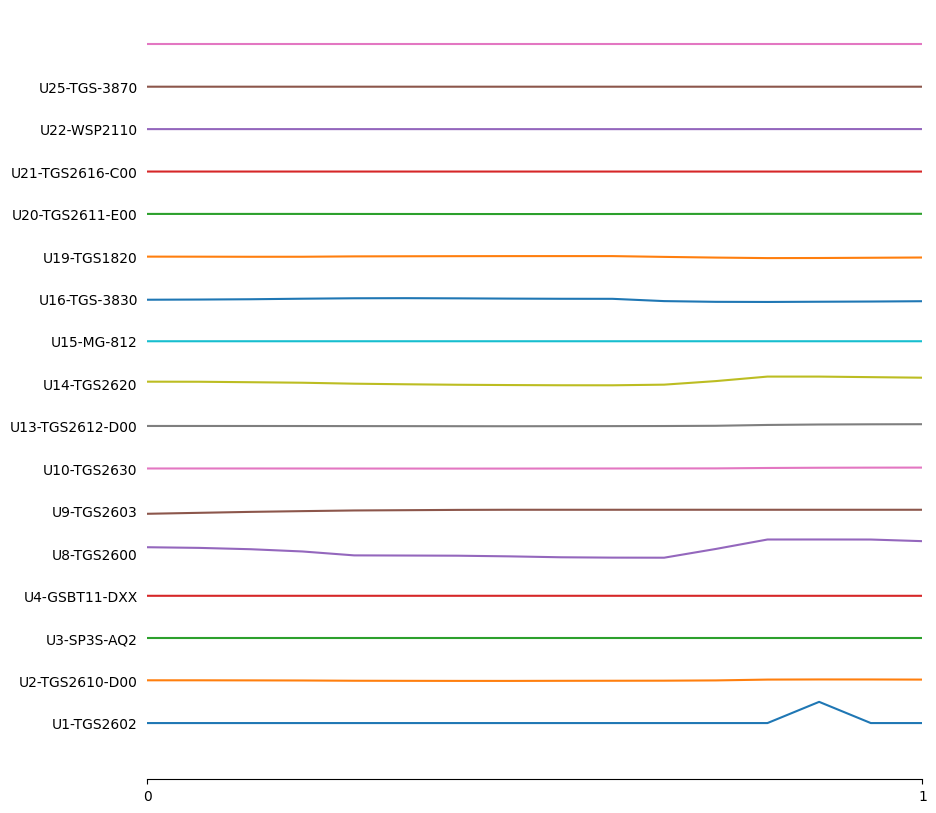

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for i, row in enumerate(sensor_data):
    baseline = np.mean(row[:10])
    signal = (np.array(row) - baseline)/65536.
    if i==0:
        ax.plot(times, signal, label=sensor_id[i])
    else:
        ax.plot(times, signal*6 + 2*i , label=sensor_id[i])
ax.set_yticks(2*np.arange(16), labels=sensor_id[:-1])
ax.set_xticks([times[0], times[-1]], labels=[0,1])
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.tick_params(left=False, labelleft=True)
ax.set_xlim([times[0], times[-1]])
ax.fill([58,58,118,118], [-1,31,31,-1], color='gray', alpha=0.2)
plt.savefig('figs/test.png', dpi=300)